<a href="https://colab.research.google.com/github/Riky2014/NAPDE/blob/main/cerchi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
%%capture

!pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"
!pip install GPUtil
from GPUtil import showUtilization as gpu_usage
gpu_usage()

# Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import and set directory

In [13]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import monai
import numpy as np
from glob import glob
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
from nibabel import load, save, Nifti1Image

import torch
import logging
import sys
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from monai.data import create_test_image_2d, list_data_collate, decollate_batch, DataLoader
from monai.visualize import plot_2d_or_3d_image

import gc
gc.collect()
torch.cuda.empty_cache()

print_config()


"""
global ConvertToMultiChannelBasedOnBratsClassesd
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
  def __call__(self, data):
    d = dict(data)
    for key in self.keys:
      result = []
      result.append(d[key] == 0)
      result.append(torch.logical_or(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1), d[key] == 4))
      d[key] = torch.stack(result, axis=0).float()
    return d
"""

os.environ["MONAI_DATA_DIRECTORY"] = "/content/drive/MyDrive/prova_cerchi_dir"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

MONAI version: 1.4.dev2410
Numpy version: 1.25.2
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 1e2d41aaa1e494066c8d35fbfae807226cad6227
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.7.0
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visi

# Create images

In [14]:
# create 40 random image, mask pairs
print(f"generating synthetic data to {root_dir} (this may take a while)")
for i in range(40):
  image, label = create_test_image_2d(128, 128, num_seg_classes=1)
  Image.fromarray((image * 255).astype("uint8")).save(os.path.join(root_dir, f"image{i:d}.png"))
  Image.fromarray((label * 255).astype("uint8")).save(os.path.join(root_dir, f"label{i:d}.png"))

generating synthetic data to /content/drive/MyDrive/prova_cerchi_dir (this may take a while)


# Prepare data

image shape: torch.Size([1, 128, 128])
metatensor(2.3413)
label shape: torch.Size([1, 128, 128])
metatensor(0.6539)


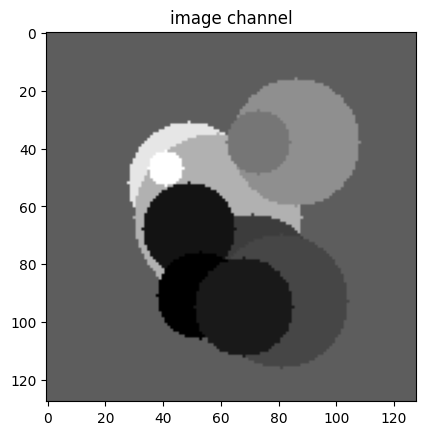

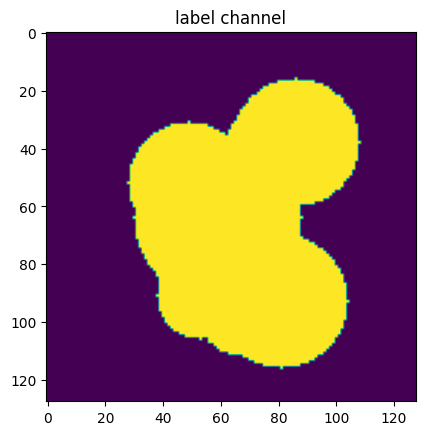

In [16]:
set_determinism(seed=0)

images = sorted(glob(os.path.join(root_dir, "image*.png")))
labels = sorted(glob(os.path.join(root_dir, "label*.png")))
train_files = [{"image": image, "label": label} for image, label in zip(images[:20], labels[:20])]
val_files = [{"image": image, "label": label} for image, label in zip(images[-20:], labels[-20:])]

train_transform = Compose(
[
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image","label"]),
    EnsureTyped(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RA"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0),
        mode=("bilinear", "nearest"),
    ),
    RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128], random_size=False),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    NormalizeIntensityd(keys="label", divisor= 255.0),
    RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
    RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
]
)

val_transform = Compose(
[
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image","label"]),
    EnsureTyped(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RA"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0),
        mode=("bilinear", "nearest"),
    ),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    NormalizeIntensityd(keys="label", divisor= 255.0),
]
)

train_ds = monai.data.Dataset(data=train_files, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

#check_data = monai.utils.misc.first(val_loader)
#print(check_data["image"].shape, check_data["label"].shape)

# pick one image to visualize and check the channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image")  # (24, 110) come secondo argomento di "figure"
                  # per i due assi "lunghi", (24, 60) per quello "corto"

for i in range(1):                  # 34
  plt.subplot(1, 1, 1)            # 9, 4, i+1
  plt.title(f"image channel")
  print(val_data_example["image"][0, :, :].detach().cpu().max())
  plt.imshow(val_data_example["image"][0, :, :].detach().cpu(), cmap="gray")     # 0, :, :, i*5

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label")

for i in range(1):
  plt.subplot(1, 1, 1)
  plt.title(f"label channel")
  print(val_data_example["label"][0, :, :].detach().cpu().max())
  plt.imshow(val_data_example["label"][0, :, :].detach().cpu())

plt.show()

# Set training parameters

In [17]:
# CHOOSE MAX EPOCHS
max_epochs = 5
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
  spatial_dims = 2,
  blocks_down=[1, 2, 4, 8, 16],
  blocks_up=[1, 1, 1, 1],
  init_filters=16,
  in_channels=1,
  out_channels=1,
  dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-7)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
# dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
def _compute(input):
      return sliding_window_inference(
          inputs=input,
          roi_size=(128, 128),
          sw_batch_size=1,
          predictor=model,
          overlap=0.5,
      )

def inference(input):
  """
  def _compute(input):
      return sliding_window_inference(
          inputs=input,
          roi_size=(128, 128),
          sw_batch_size=1,
          predictor=model,
          overlap=0.5,
      )
  """

  if VAL_AMP:
      with torch.cuda.amp.autocast():
          return _compute(input)
  else:
      return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# Train the NN

----------
epoch 1/5


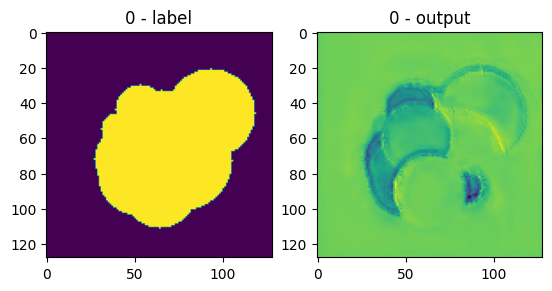

epoch 1 average loss: 0.7900
metatensor(5459.)
metatensor(5728.)


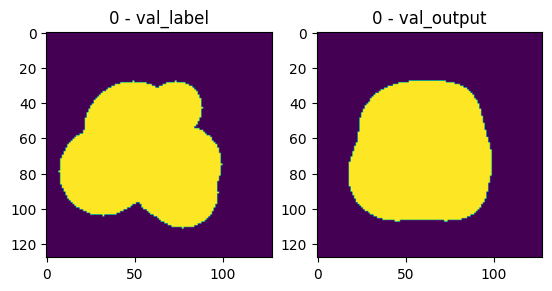

Dice Metric: 0.8327324986457825
saved new best metric model
current epoch: 1 current mean dice: 0.8327
best mean dice: 0.8327 at epoch: 1
time consuming of epoch 1 is: 5.8818
----------
epoch 2/5


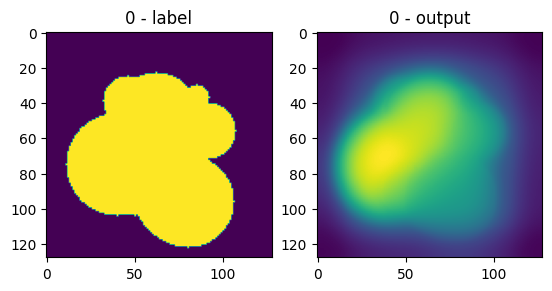

epoch 2 average loss: 0.6043
metatensor(5670.)
metatensor(5728.)


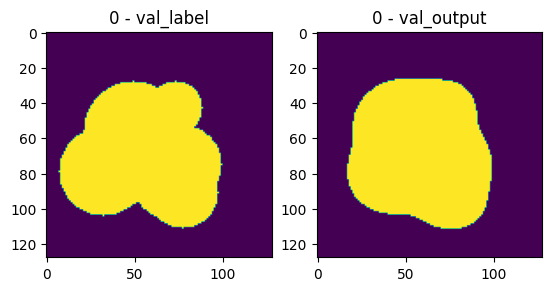

Dice Metric: 0.9104993939399719
saved new best metric model
current epoch: 2 current mean dice: 0.9105
best mean dice: 0.9105 at epoch: 2
time consuming of epoch 2 is: 5.7596
----------
epoch 3/5


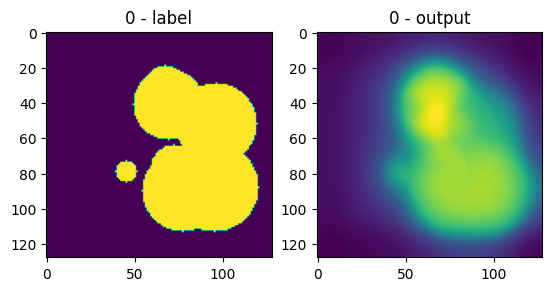

epoch 3 average loss: 0.5243
metatensor(5359.)
metatensor(5728.)


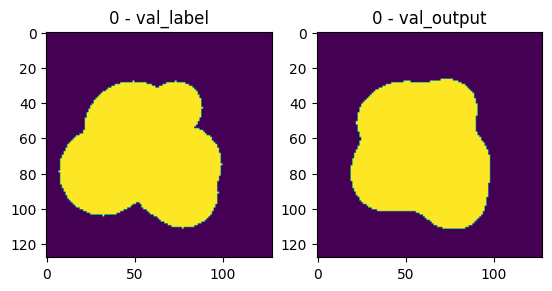

Dice Metric: 0.9345830678939819
saved new best metric model
current epoch: 3 current mean dice: 0.9346
best mean dice: 0.9346 at epoch: 3
time consuming of epoch 3 is: 5.3440
----------
epoch 4/5


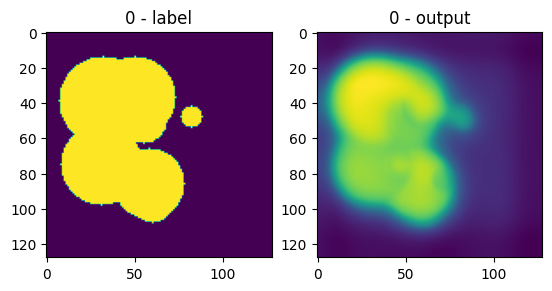

epoch 4 average loss: 0.4725
metatensor(5262.)
metatensor(5728.)


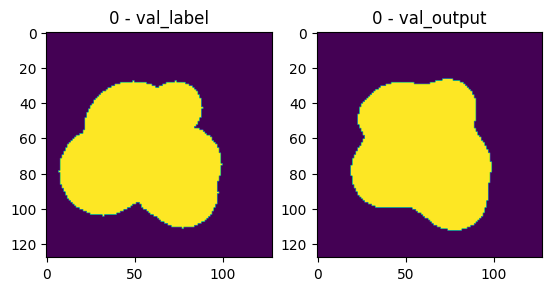

Dice Metric: 0.9452379941940308
saved new best metric model
current epoch: 4 current mean dice: 0.9452
best mean dice: 0.9452 at epoch: 4
time consuming of epoch 4 is: 6.3917
----------
epoch 5/5


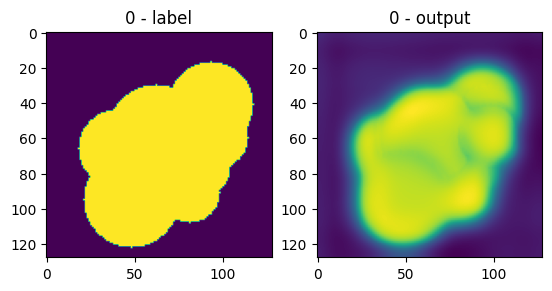

epoch 5 average loss: 0.4528
metatensor(5216.)
metatensor(5728.)


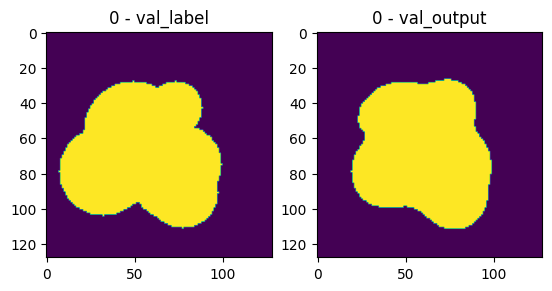

Dice Metric: 0.9462965130805969
saved new best metric model
current epoch: 5 current mean dice: 0.9463
best mean dice: 0.9463 at epoch: 5
time consuming of epoch 5 is: 5.2684
train completed, best_metric: 0.9463 at epoch: 5, total time: 28.649075746536255.


In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
model.train()
for epoch in range(max_epochs):
  tried_already = False
  epoch_start = time.time()
  print("-" * 10)
  print(f"epoch {epoch + 1}/{max_epochs}")
  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
      step_start = time.time()
      step += 1
      inputs, labels = ( batch_data["image"].to(device), batch_data["label"].to(device) )
      optimizer.zero_grad()

      with torch.cuda.amp.autocast():
          outputs = model(inputs)
          outputs = [post_trans(i) for i in decollate_batch(outputs)]
          if not tried_already:
            fig, axs = plt.subplots(1, 2)
            axs[0].set_title(f"0 - label")
            axs[0].imshow(labels[0][0].detach().cpu())
            axs[1].set_title(f"0 - output")
            axs[1].imshow(outputs[0][0].detach().cpu())
            plt.show()
            tried_already = True
          loss = loss_function(outputs, labels)
          """
          print(loss)
          """
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      epoch_loss += loss.item()
      """
      print(
          f"{step}/{len(train_ds) // train_loader.batch_size}"
          f", train_loss: {loss.item():.4f}"
          f", step time: {(time.time() - step_start):.4f}"
      )
      """
  lr_scheduler.step()
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)
  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  if (epoch + 1) % val_interval == 0:
      model.eval()
      tried_val = False
      with torch.no_grad():
          for val_data in val_loader:
              val_inputs, val_labels = (
                  val_data["image"].to(device),
                  val_data["label"].to(device),
              )

              val_outputs = inference(val_inputs)
              val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
              val_labels = [post_trans(i) for i in decollate_batch(val_labels)]

              if not tried_val:
                  fig, axs = plt.subplots(1, 2)
                  print(val_outputs[0][0].detach().cpu().sum())
                  print(val_labels[0][0].detach().cpu().sum())
                  axs[0].set_title(f"0 - val_label")
                  axs[0].imshow(val_labels[0][0].detach().cpu())
                  axs[1].set_title(f"0 - val_output")
                  axs[1].imshow(val_outputs[0][0].detach().cpu())
                  plt.show()
                  tried_val = True

              dice_metric(y_pred=val_outputs, y=val_labels)
              """
              print(dice_metric.aggregate('sum'))
              dice_metric_batch(y_pred=val_outputs, y=val_labels)
              """
          metric = dice_metric.aggregate().item()
          print(f'Dice Metric: {metric}')
          metric_values.append(metric)
          """
          metric_batch = dice_metric_batch.aggregate()
          """
          dice_metric.reset()
          """
          dice_metric_batch.reset()
          """

          if metric > best_metric:
              best_metric = metric
              best_metric_epoch = epoch + 1
              best_metrics_epochs_and_time[0].append(best_metric)
              best_metrics_epochs_and_time[1].append(best_metric_epoch)
              best_metrics_epochs_and_time[2].append(time.time() - total_start)
              torch.save(
                  model.state_dict(),
                  os.path.join(root_dir, "best_metric_model.pth"),
              )
              print("saved new best metric model")
          print(
              f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
              f"\nbest mean dice: {best_metric:.4f}"
              f" at epoch: {best_metric_epoch}"
          )
  print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
  total_time = time.time() - total_start
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

# Plot results

In [ ]:
val_output = inference(val_input)
val_output.detach().cpu().numpy()

array([[[[-2.1015625, -2.109375 , -2.1132812, ..., -2.1464844,
          -2.1464844, -2.1367188],
         [-2.1113281, -2.1152344, -2.1191406, ..., -2.1523438,
          -2.1503906, -2.1386719],
         [-2.1210938, -2.125    , -2.1308594, ..., -2.1660156,
          -2.1660156, -2.1542969],
         ...,
         [-2.3144531, -2.3203125, -2.328125 , ..., -2.3789062,
          -2.3730469, -2.3574219],
         [-2.3066406, -2.3085938, -2.3183594, ..., -2.3691406,
          -2.3652344, -2.3496094],
         [-2.2949219, -2.2988281, -2.3046875, ..., -2.3554688,
          -2.3496094, -2.3417969]]]], dtype=float32)

# Plot the loss and metric functions

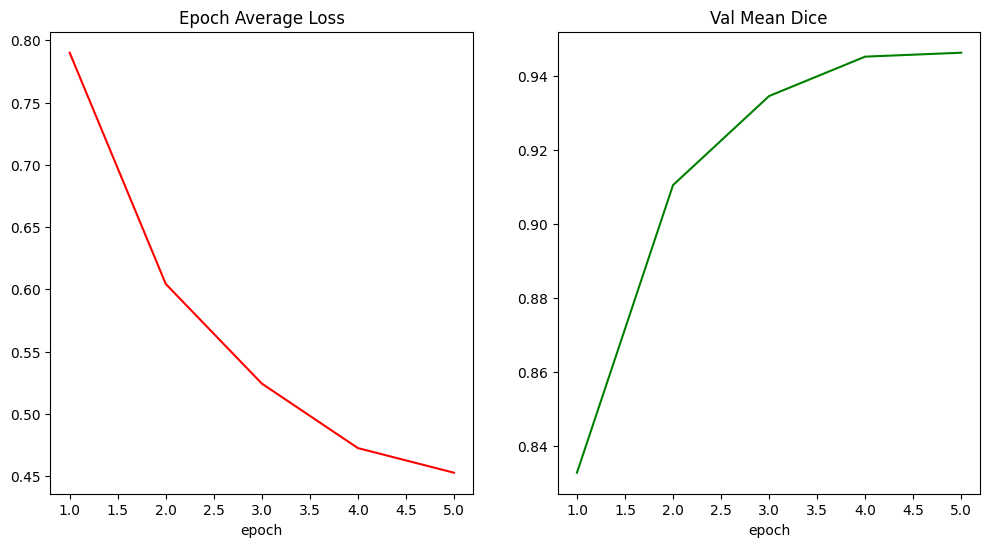

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")

plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

# Plot all the  images, the corresponding labels and the outputs

<Figure size 640x480 with 0 Axes>

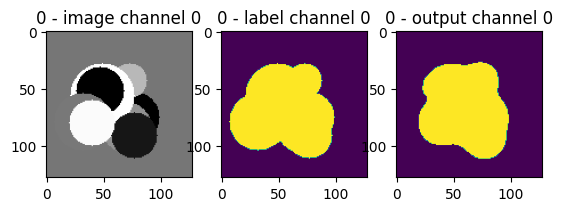

<Figure size 640x480 with 0 Axes>

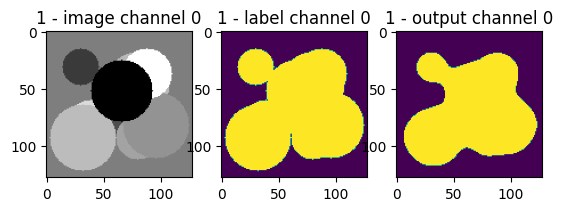

<Figure size 640x480 with 0 Axes>

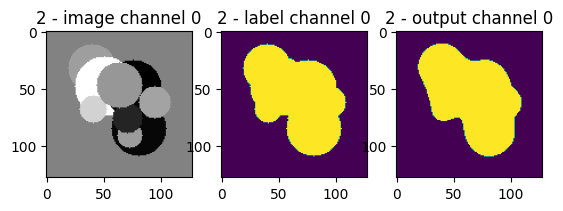

<Figure size 640x480 with 0 Axes>

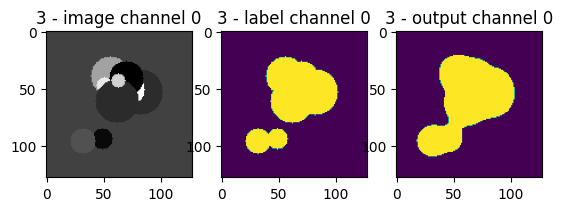

<Figure size 640x480 with 0 Axes>

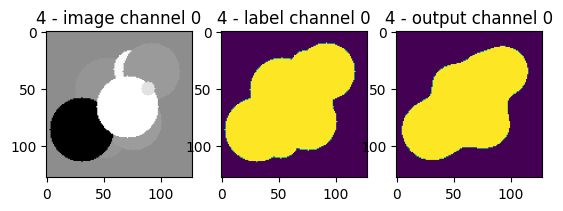

<Figure size 640x480 with 0 Axes>

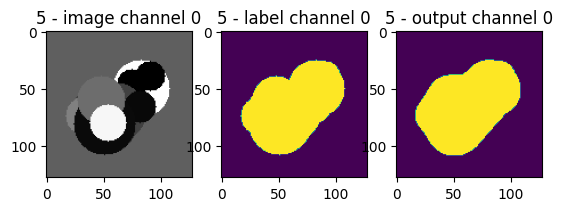

<Figure size 640x480 with 0 Axes>

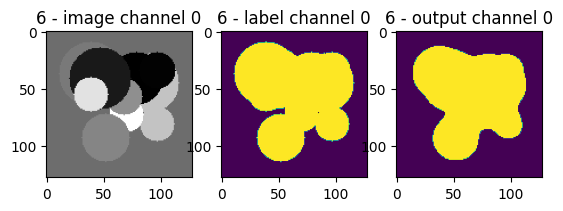

<Figure size 640x480 with 0 Axes>

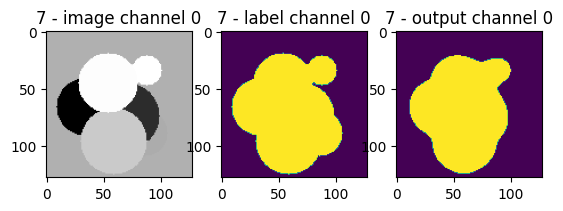

<Figure size 640x480 with 0 Axes>

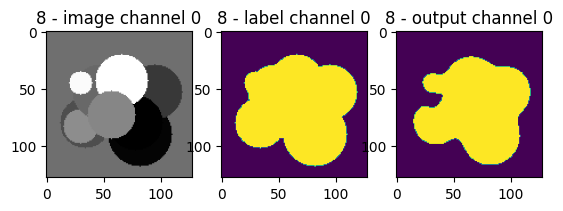

<Figure size 640x480 with 0 Axes>

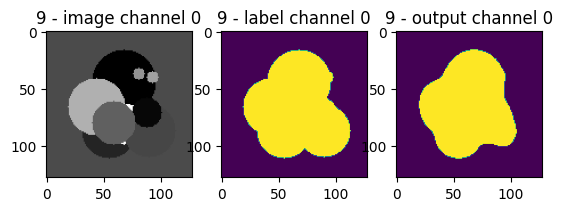

<Figure size 640x480 with 0 Axes>

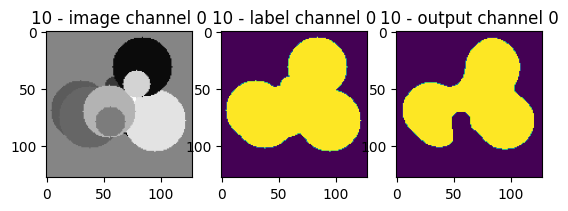

<Figure size 640x480 with 0 Axes>

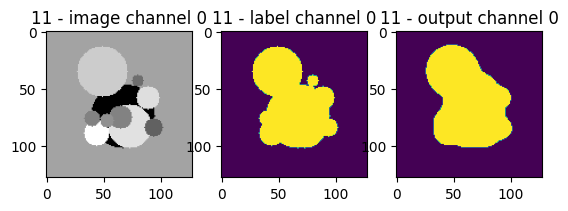

<Figure size 640x480 with 0 Axes>

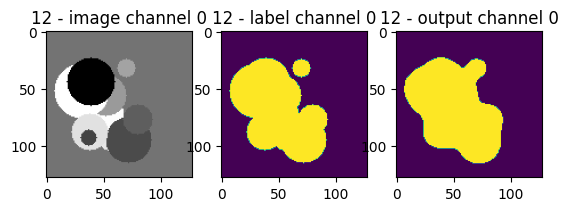

<Figure size 640x480 with 0 Axes>

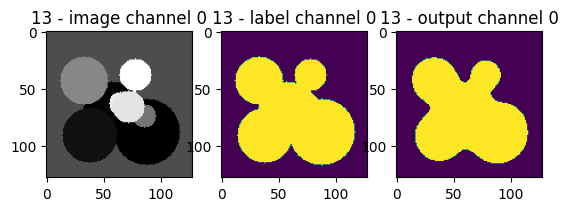

<Figure size 640x480 with 0 Axes>

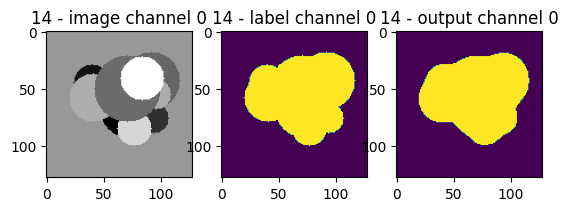

<Figure size 640x480 with 0 Axes>

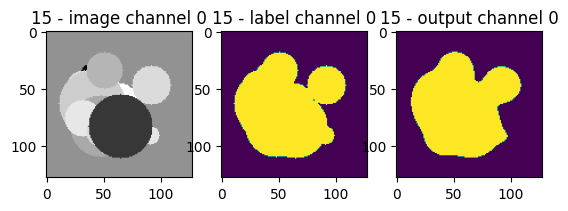

<Figure size 640x480 with 0 Axes>

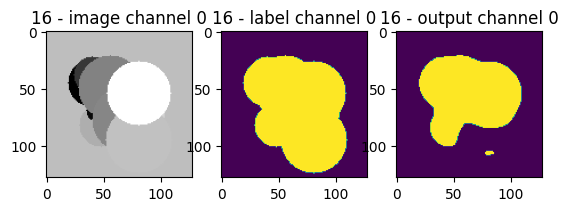

<Figure size 640x480 with 0 Axes>

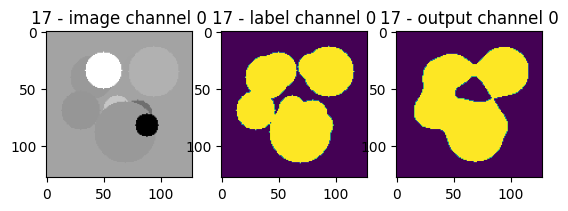

<Figure size 640x480 with 0 Axes>

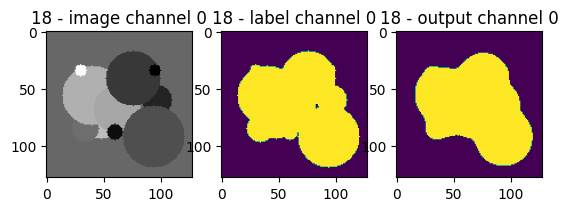

<Figure size 640x480 with 0 Axes>

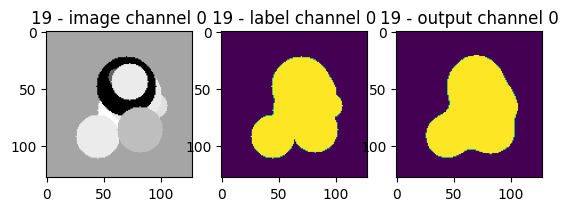

In [ ]:
# check best model output with the input image and label
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

# visualize input images, corresponding labels and outputs
for i in range(20):
  with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[i]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128)
    sw_batch_size = 4
    val_outputs = sliding_window_inference(val_input, roi_size, sw_batch_size, model) # default: overlap = 0.25 (vs 0.5)
    val_outputs = post_trans(val_outputs[0])
    """
    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
    """
    plt.figure("fig")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.set_title(f"{i} - image")
    ax1.imshow(val_ds[i]["image"][0, :, :].detach().cpu(), cmap="gray")
    # visualize the channel label corresponding to this image
    ax2.set_title(f"{i} - label")
    ax2.imshow(val_ds[i]["label"][0, :, :].detach().cpu())
    # visualize the channel model output corresponding to this image
    ax3.set_title(f"{i} - output")
    ax3.imshow(val_outputs[0, :, :].detach().cpu())
    plt.show()

Error is 0.307
1.0 1.0
output: 7986.0 with dims torch.Size([1, 128, 128]) and 16384 pixels
label: 9254.0 with dims torch.Size([1, 128, 128]) and 16384 pixels


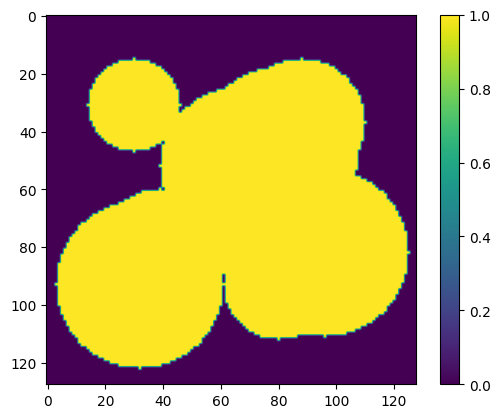

In [ ]:
print(f'Error is {errore:.3f}')
print(val_output.cpu().numpy().max(), val_label.cpu().numpy().max())
print(f'output: {val_output.sum()} with dims {val_output.shape} and {val_output.shape[-1]*val_output.shape[-2]} pixels')
print(f'label: {val_label.sum()} with dims {val_label.shape} and {val_label.shape[-1]*val_label.shape[-2]} pixels')
plt.imshow(val_label.cpu().numpy()[0])
plt.colorbar()
plt.show()

# val_output
# val_label.aggregate()

# val_output-val_label

In [ ]:
print(val_output.cpu().numpy().max(), val_label.cpu().numpy().max())

1.0 1.0


# Choose an image to be plotted (modify "img_to_show")

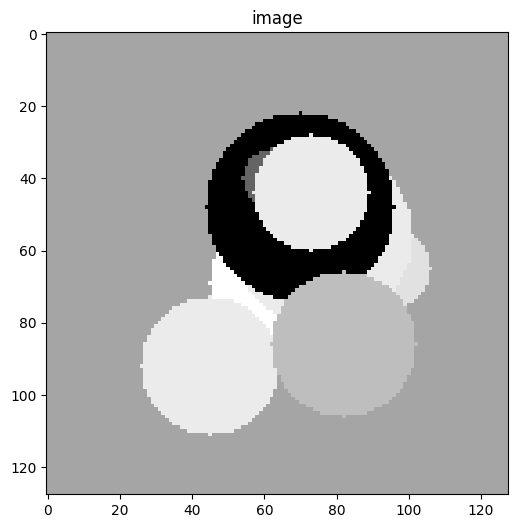

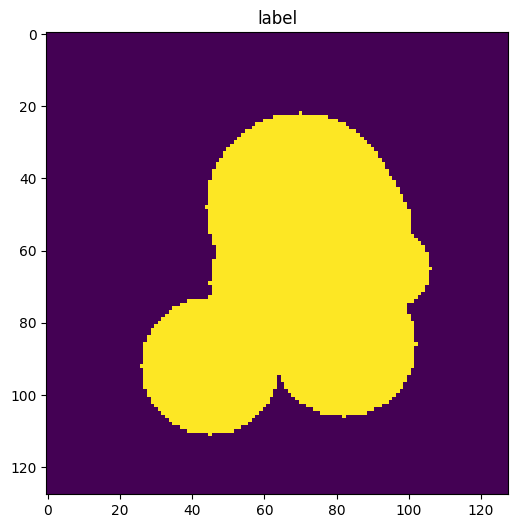

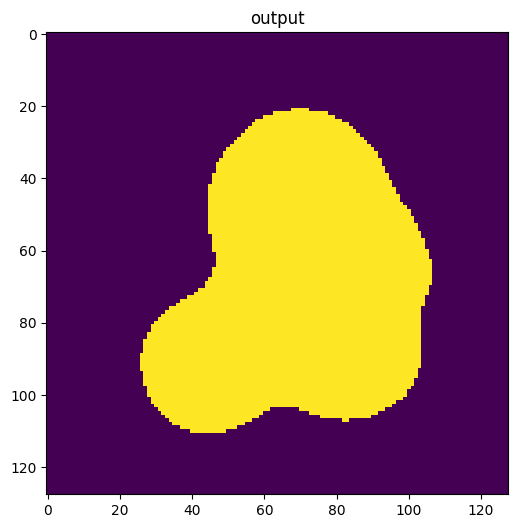

In [ ]:
# check best model output with the input image and label
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

# choose the index of the image to be plotted
img_to_show = 19

with torch.no_grad():
  # select one image to evaluate and visualize the model output
  val_input = val_ds[img_to_show]["image"].unsqueeze(0).to(device)
  roi_size = (128, 128)
  sw_batch_size = 4
  val_output = inference(val_input)
  val_output = post_trans(val_output[0])

  # choose an  image and visualize it
  plt.figure("image", (6, 6))
  plt.subplot()
  plt.title(f"image")
  plt.imshow(val_ds[img_to_show]["image"][0, :, :].detach().cpu(), cmap="gray")
  plt.show()

  # visualize the channel label corresponding to this image
  plt.figure("label", (6, 6))
  plt.subplot()
  plt.title(f"label")
  plt.imshow(val_ds[img_to_show]["label"][0, :, :].detach().cpu())
  plt.show()

  # visualize the channel model output corresponding to this image
  plt.figure("output", (6, 6))
  plt.subplot()
  plt.title(f"output")
  plt.imshow(val_output[0, :, :].detach().cpu())
  plt.show()

# FINE

ValueError: not enough values to unpack (expected 3, got 2)

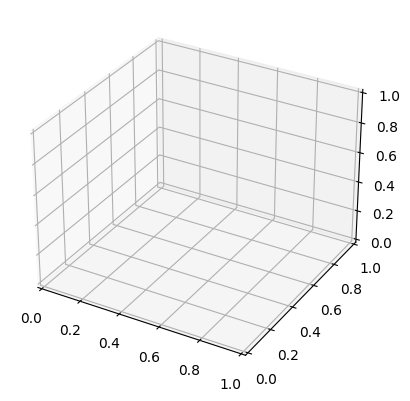

In [ ]:
#PLOTTING 3D IMAGES FOR INPUT IMAGES, CHANNEL LABELS AND MODEL OUTPUT
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
  for i in range(5):
    val_input = val_ds[i]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    z, x, y = val_ds[i]["label"][0].astype(np.uint8).nonzero()
    ax.scatter(x, y, z)
    plt.xlim([0,256])
    plt.ylim([0,256])
    plt.title(f"label channel, {i}")


    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    z, x, y = val_output[0].astype(np.uint8).nonzero()
    ax.scatter(x, y, z)
    plt.xlim([0,256])
    plt.ylim([0,256])
    plt.title(f"output channel, {i}")

In [ ]:
# check best model output with the input image and label
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

# choose the index of the image to be plotted
img_to_plot = 1

with torch.no_grad():
  # select one image to evaluate and visualize the model output
  val_input = val_ds[img_to_plot]["image"].unsqueeze(0).to(device)
  roi_size = (128, 128)
  sw_batch_size = 4
  val_output = inference(val_input)
  val_output = post_trans(val_output[0])

  val_label = val_ds[img_to_plot]["label"].to(device)
  val_label = post_trans(val_label)
  """
  zero_label = torch.full_like(val_label, 0.0)
  one_label = torch.full_like(val_label, 1.0)
  """

  errore = loss_function(val_output, val_label)
  errore = errore.item()
  print(f'Error on this sample is {errore:.3f}')

  # choose an image and visualize it
  plt.figure("image")
  plt.subplot(1, 1, 1)
  plt.title(f"image channel {0}")
  plt.imshow(val_ds[img_to_plot]["image"][0, :, :].detach().cpu(), cmap="gray")
  plt.colorbar()
  plt.show()

  # visualize the channel label corresponding to this image
  plt.figure("label")
  plt.subplot(1, 1, 1)
  plt.title(f"label channel {0}")
  plt.imshow(val_label.detach().cpu().numpy()[0])
  plt.colorbar()
  plt.show()

  # visualize the channel model output corresponding to this image
  plt.figure("output")
  plt.subplot(1, 1, 1)
  plt.title(f"output channel {0}")
  plt.imshow(val_output.detach().cpu().numpy()[0])
  plt.colorbar()
  plt.show()